# Text Analysis of Subreddits - Collaborative Project

The purpose of this project is to analyse the differences and similarities between different subreddits existing around a common topic. At first, we will collect Reddit data, analyse TF-IDF scores, and attempt to classify the subreddits using k-means and Naive Bayes algorithms. Then, we will introduce networks to visualise connections between threaded comments and users.

In [109]:
# Setup autoreload
%load_ext autoreload
%autoreload 2

# Create README.md 
# pip3 install nbconvert
# jupyter nbconvert --execute --to markdown RedditTextAnalysis.ipynb
# then rename to README.md

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Collecting Reddit Data and EDA

In [110]:
# Import necessary modules
import os
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from config.settings import USER_AGENT
from models.reddit_scraper import RedditScraper
from utils.analysis import *
from datetime import datetime

In [111]:
subs_of_interest = ['islam', 'Christianity', 'atheism', 'Buddhism']

In [112]:
# scraper = RedditScraper(USER_AGENT)

# subs_of_interest = ['islam', 'atheism', 'Christianity', 'Buddhism']

# results = {} 

# for sub in subs_of_interest:    
#     posts = scraper.get_subreddit_posts(sub, limit=1000, cache=True)
#     posts_df = create_posts_dataframe(posts)
    
#     tfidf_results = tfidf_analyze_subreddit(posts, include_selftext=True)
#     # tfidf_results = tfidf_analyze_subreddit(posts)
#     tf_idf_scores = get_mean_tfidf(
#         tfidf_matrix=tfidf_results['tfidf_matrix'],
#         feature_names=tfidf_results['feature_names'],
#         return_df=True
#     )
#     results[sub] = {"posts_df":posts_df,
#                     "tfidf_results":tfidf_results,
#                     "tf_idf_scores":tf_idf_scores}

# # Ensure the data directory exists
# os.makedirs("data", exist_ok=True)

# # Just a backup of all the files, not used in the analysis directly
# with open("data/results.pkl", "wb") as f:
#     pickle.dump(results, f)

In [113]:
# Code to open the pickle
with open("data/results.pkl", "rb") as f:
    results = pickle.load(f)

print(results.keys())
print(results['islam'].keys())
print(results['islam']['posts_df']['selftext'][1])
print(results['islam']['posts_df']['selftext'].value_counts())


dict_keys(['islam', 'atheism', 'Christianity', 'Buddhism'])
dict_keys(['posts_df', 'tfidf_results', 'tf_idf_scores'])
I could be in the worst of the worst situations and I read maghrib then POOF its all gone, people who genuinely follow the religion are the best people unlike most people this gen vaping and going to parties thinking its cool.
selftext
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

## Part 0/ Initial Similarity Analysis: Common Word Use

### Jaccard Similarity Analysis

In [114]:
# Extract the vocabulary for each subreddit
vocabularies = {sub: set(results[sub]['tfidf_results']['feature_names']) for sub in subs_of_interest}

# Get the intersection of the vocabularies
common_vocab = set.intersection(*vocabularies.values())

# Report analytics
print(f"Number of common terms across all subreddits: {len(common_vocab)}")
print(f"Common terms: {', '.join(list(common_vocab)[:10])}...")  # Display first 10 common terms

# Calculate Jaccard similarity for each pair of subreddits
for sub1 in subs_of_interest:
    for sub2 in subs_of_interest:
        if sub1 > sub2:
            intersection = vocabularies[sub1].intersection(vocabularies[sub2])
            union = vocabularies[sub1].union(vocabularies[sub2])
            jaccard_similarity = len(intersection) / len(union)
            print(f"Jaccard similarity between {sub1} and {sub2}: {jaccard_similarity:.3f}")

# Report unique terms for each subreddit
for sub in subs_of_interest:
    unique_terms = vocabularies[sub] - common_vocab
    print(f"Number of unique terms in {sub}: {len(unique_terms)}")
    print(f"Unique terms in {sub}: {', '.join(list(unique_terms)[:10])}...")  # Display first 10 unique terms

Number of common terms across all subreddits: 504
Common terms: lot, confuse, seem, peace, personal, pain, beyond, choice, provide, body...
Jaccard similarity between islam and Christianity: 0.507
Jaccard similarity between islam and atheism: 0.478
Jaccard similarity between islam and Buddhism: 0.449
Jaccard similarity between Christianity and Buddhism: 0.465
Jaccard similarity between atheism and Christianity: 0.570
Jaccard similarity between atheism and Buddhism: 0.451
Number of unique terms in islam: 496
Unique terms in islam: sister, student, detail, consistent, test, wait, extra, draw, spend, muslim...
Number of unique terms in Christianity: 496
Unique terms in Christianity: adult, sister, society, rich, vote, hebrew, test, democrat, wait, commandment...
Number of unique terms in atheism: 496
Unique terms in atheism: adult, sister, student, society, hospital, vote, test, democrat, wait, commandment...
Number of unique terms in Buddhism: 496
Unique terms in Buddhism: student, karmi

In [115]:
# Create a dataframe for the common terms
common_terms_df = pd.DataFrame(index=list(common_vocab))

# Add TF-IDF scores for each subreddit
for sub in subs_of_interest:
    common_terms_df[sub] = results[sub]['tf_idf_scores'].reindex(common_vocab)['score']

# Calculate the average TF-IDF score (mean)
common_terms_df['average'] = common_terms_df.mean(axis=1)

# Sort by the average score
common_terms_df = common_terms_df.sort_values(by='average', ascending=False)

# Report the top 5 words
top_10_words = common_terms_df.head(10)
print(top_10_words)

              islam  Christianity   atheism  Buddhism   average
god        0.010797      0.063861  0.049284  0.005514  0.032364
like       0.028393      0.035562  0.032741  0.030480  0.031794
say        0.031983      0.031933  0.034042  0.019651  0.029402
know       0.031963      0.034275  0.022006  0.026502  0.028687
people     0.021027      0.027581  0.037505  0.021942  0.027014
make       0.028106      0.029666  0.026333  0.022021  0.026531
get        0.026881      0.029330  0.028091  0.021425  0.026432
want       0.026765      0.029164  0.022911  0.023731  0.025643
christian  0.007259      0.045291  0.042978  0.004918  0.025112
feel       0.025264      0.032137  0.017765  0.024555  0.024930


## Part I/ Similarity in Analytical vs. Emotional Thinking?

In [116]:
from utils.analytical_utils import *

### 1) Analytical Thinking

- Cosine Distance (Think vs. Feel) -- careful with lemmatisation

- Dictionary (handcrafted) to score analytical thinking

In [117]:
tf_idf_vectors_feel_think = create_tf_idf_vectors(results, subs_of_interest, 'feel', 'think')
print(tf_idf_vectors_feel_think)

{'islam': array([0.02526407, 0.01771909]), 'Christianity': array([0.03213678, 0.02863543]), 'atheism': array([0.01776503, 0.0260029 ]), 'Buddhism': array([0.02455521, 0.02283826])}


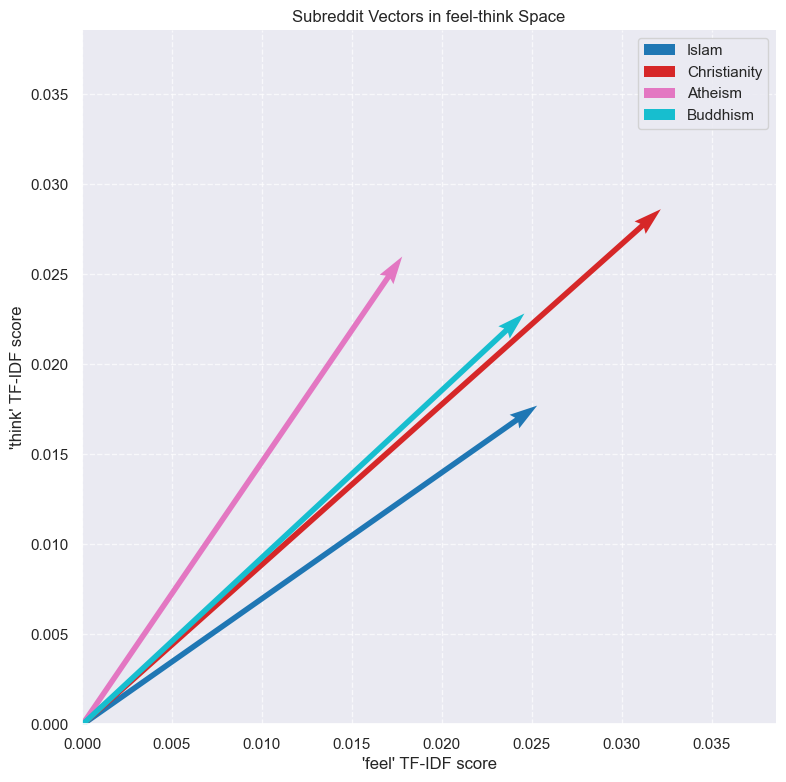

Distance between Christianity and islam: 0.01
Distance between Christianity and atheism: 0.01
Distance between atheism and islam: 0.01
Distance between Buddhism and islam: 0.01
Distance between Buddhism and Christianity: 0.01
Distance between Buddhism and atheism: 0.01

Angles between subreddit vectors:
Christianity vs islam: 6.7°
Christianity vs atheism: 14.0°
atheism vs islam: 20.6°
Buddhism vs islam: 7.9°
Buddhism vs Christianity: 1.2°
Buddhism vs atheism: 12.7°


In [118]:
plot_subreddit_term_space(tf_idf_vectors_feel_think, 'feel', 'think')
report_distances(tf_idf_vectors_feel_think)

We now employ a dictionary-based approach to quantify the extent of analytical thinking present in the subreddits' posts.  

In [119]:
# Process subreddit dataframes
islam_df = process_subreddit_subjectivity(results, 'islam')
atheism_df = process_subreddit_subjectivity(results, 'atheism')
christianity_df = process_subreddit_subjectivity(results, 'Christianity')
buddhism_df = process_subreddit_subjectivity(results, 'Buddhism')

In [132]:
# Create dictionaries for analytical thinking scale
analytical_words = {
     "assume", "research", "although", "despite", "knowledge", "though", "proof",
    "evidence", "rather", "explain", "regardless", "example", "know", "truth",
    "information", "reason", "explanation", "concept", "think", "however", "meaning",
    "result", "thought", "therefore", "measure", "whereas", "logical", "rational",
    "compare", "contrast", "interpret", "debate"
    }
emotional_words = {
    "really", "hurt", "trust", "worst", "deeply", "concern", "sad", "beautiful",
    "happy", "appreciate", "fight", "depression", "believe", "confused", "comfortable",
    "harm", "worried", "anxiety", "love", "fun", "evil", "feeling", "feel", "fear",
    "heart", "grateful", "regret", "guilty", "care", "hate", "emotional", "comfort",
    "dislike", "desire", "angry", "terrible", "wish"
}

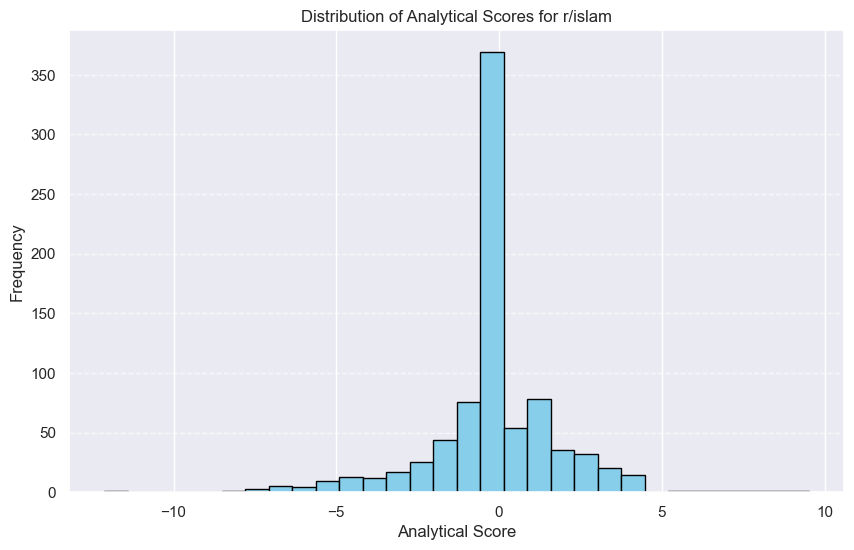

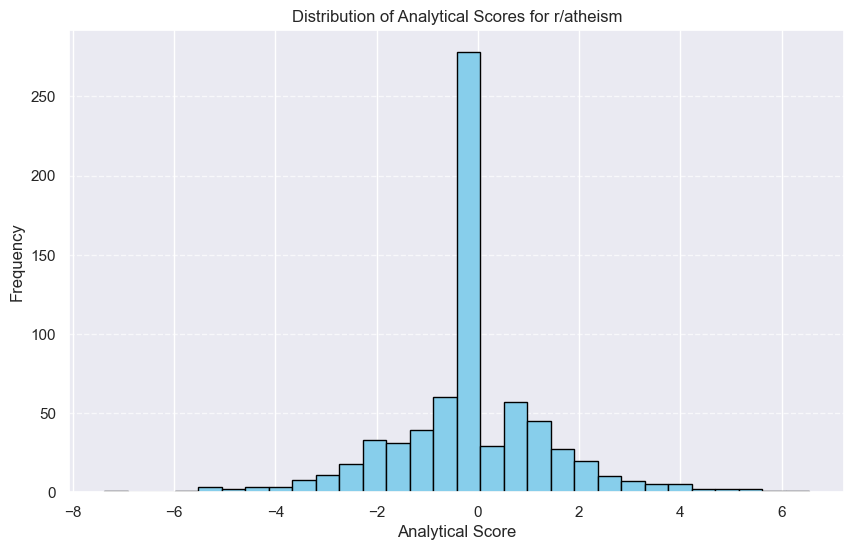

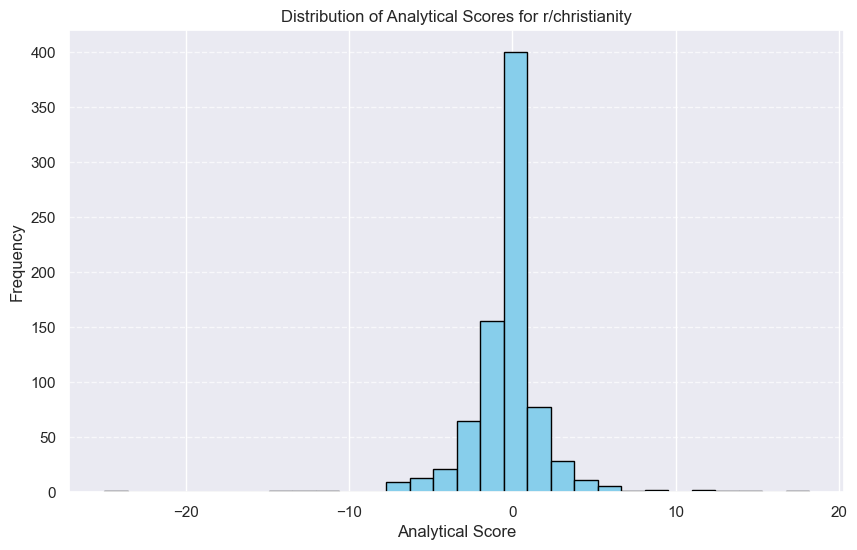

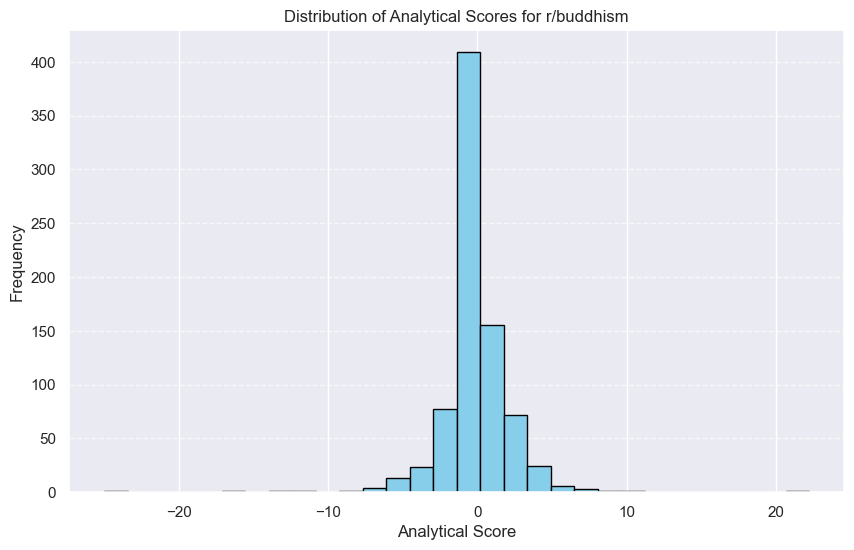

In [133]:
scored_islam_df = analyze_and_plot_analytical_score(islam_df, analytical_words, emotional_words, sub_name='r/islam')
scored_atheism_df = analyze_and_plot_analytical_score(atheism_df, analytical_words, emotional_words, sub_name='r/atheism')
scored_christianity_df = analyze_and_plot_analytical_score(christianity_df, analytical_words, emotional_words, sub_name='r/christianity')
scored_buddhism_df = analyze_and_plot_analytical_score(buddhism_df, analytical_words, emotional_words, sub_name='r/buddhism')

              count      mean       std        min       25%  50%       75%  \
subreddit                                                                     
Atheism       704.0 -0.079470  1.528202  -7.377049 -0.701339  0.0  0.554018   
Buddhism      794.0  0.015529  2.401736 -25.000000 -0.641034  0.0  0.825879   
Christianity  798.0 -0.272271  2.502813 -25.000000 -1.054823  0.0  0.215286   
Islam         818.0 -0.082078  1.972027 -12.121212 -0.626959  0.0  0.681484   

                    max  
subreddit                
Atheism        6.542056  
Buddhism      22.222222  
Christianity  18.181818  
Islam          9.523810  


/Users/matteolarrode/Documents/Oxford/Fundamentals of Python for SDS/Week 4/FSDS-RedditTextAnalysis/utils/analytical_utils.py:198: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  - *dataframes (pd.DataFrame): Dataframes to compare.


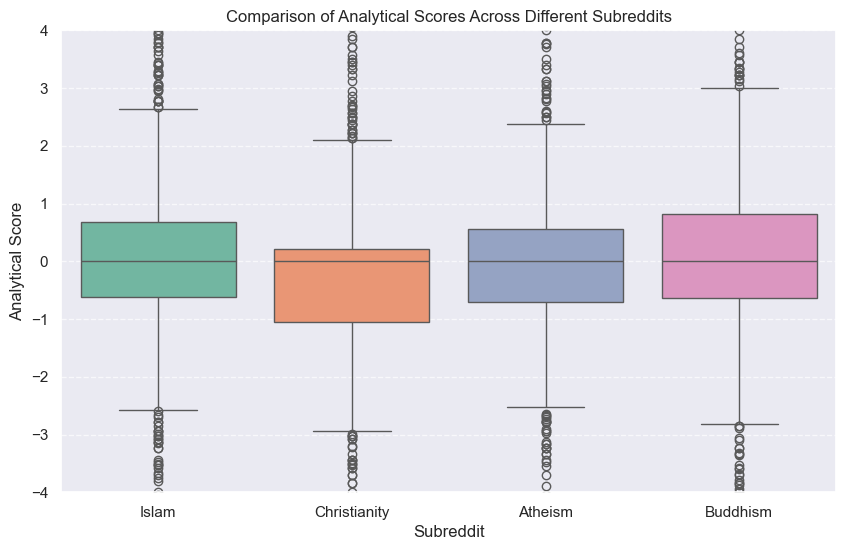

In [134]:
summary_stats = compare_analytical_scores(
    subs_of_interest, 
    scored_islam_df, 
    scored_christianity_df, 
    scored_atheism_df, 
    scored_buddhism_df
)

### 2) Sentiment analysis: Objectivity vs. Subjectivity

- Lexicon based (Pang & Lee, 2004) - nltk.sentiment.util.demo_sent_subjectivity()

In [135]:
avg_subj_islam = islam_df['subjectivity'].mean()
avg_subj_atheism = atheism_df['subjectivity'].mean()
avg_subj_christianity = christianity_df['subjectivity'].mean()
avg_subj_buddhism = buddhism_df['subjectivity'].mean()

All subredddits display average subjectivity between 0.45 and 0.47. It looks like the subjectivity / objectivity scale doesn't really pick up on any patterns here.

## Part II/ Similarity in Word Associations

### Plotting Word Similarities #1: MDS

In [136]:
# from utils.analysis import plot_word_similarities_mds

# for sub in subs_of_interest:
#     plot_word_similarities_mds(results[sub]['tfidf_results']['tfidf_matrix'], 
#                                results[sub]['tfidf_results']['feature_names'],
#                                n_terms=20,
#                                title=sub)
#     plt.show()


### Plotting the word similarities #2: Using t-SNE

In [137]:
# from utils.analysis import plot_word_similarities_tsne

# for sub in subs_of_interest:
#     fig, ax = plot_word_similarities_tsne(results[sub]['tfidf_results']['tfidf_matrix'], 
#                                      results[sub]['tfidf_results']['feature_names'],
#                                      n_highlight=20,
#                                      title=sub)
#     plt.show();

In [138]:
# Import all word association functions
from utils.word_association_utils import *


Filtered Word Frequency for 'death':
death: 76


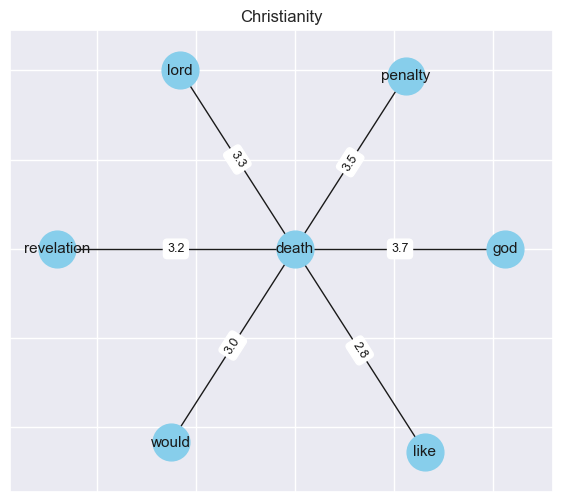

In [139]:
# Preprocess and analyze the data
subreddit_of_interest = "Christianity" # ADJUST  for graph title

df = prepare_dataframe(christianity_df) # ADJUST dataframes
target_word = "death"  # ADJUST word of interest
filtered_pairs = calculate_frequencies(df, target_word)

# Plot PMI graph
plot_pmi_graph(filtered_pairs, target_word, subreddit_of_interest)

## Part III/ ML Classification of Posts

In [141]:
cols = ['author','id','num_comments','score','title','selftext','subreddit']

for name, df in list(globals().items()):
    if name.endswith('_df'):
        if all(col in df.columns for col in cols):
            df = df[cols]
            globals()[name] = df    

df = pd.concat([islam_df, atheism_df, christianity_df, buddhism_df])

In [143]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from utils.classification import *

In [144]:
X_text = df['selftext'] + ' ' + df['title']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)

In [145]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words='english',
    max_df= 0.85 # ignore terms that appear in more than 85% of the documents
    )

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [165]:
nb_model = MultinomialNB()
svm_model = LinearSVC(random_state=42)
logreg_model = LogisticRegression(random_state=42)

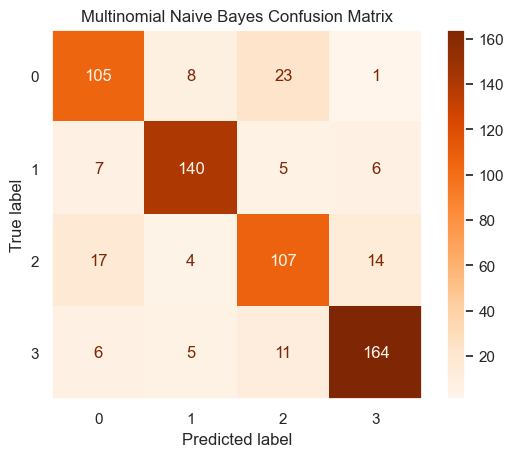

('              precision    recall  f1-score   support\n\n     Atheism       0.78      0.77      0.77       137\n    Buddhism       0.89      0.89      0.89       158\nChristianity       0.73      0.75      0.74       142\n       Islam       0.89      0.88      0.88       186\n\n    accuracy                           0.83       623\n   macro avg       0.82      0.82      0.82       623\nweighted avg       0.83      0.83      0.83       623\n',
 array([[105,   8,  23,   1],
        [  7, 140,   5,   6],
        [ 17,   4, 107,  14],
        [  6,   5,  11, 164]]))

In [166]:
train_and_display_confusion_matrix(nb_model, X_train_tfidf,X_test_tfidf, y_train, y_test, 'Multinomial Naive Bayes')

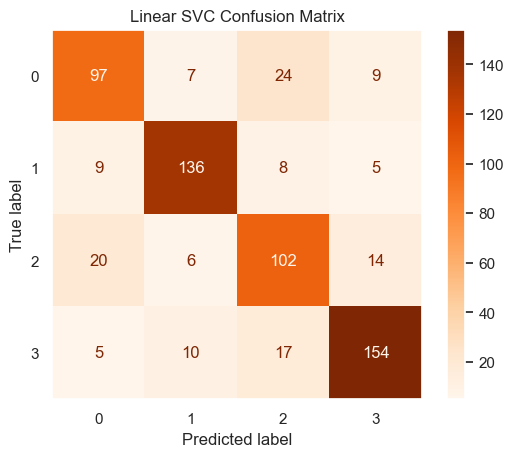

('              precision    recall  f1-score   support\n\n     Atheism       0.74      0.71      0.72       137\n    Buddhism       0.86      0.86      0.86       158\nChristianity       0.68      0.72      0.70       142\n       Islam       0.85      0.83      0.84       186\n\n    accuracy                           0.78       623\n   macro avg       0.78      0.78      0.78       623\nweighted avg       0.79      0.78      0.79       623\n',
 array([[ 97,   7,  24,   9],
        [  9, 136,   8,   5],
        [ 20,   6, 102,  14],
        [  5,  10,  17, 154]]))

In [154]:
train_and_display_confusion_matrix(svm_model, X_train_tfidf,X_test_tfidf, y_train, y_test, 'Linear SVC')

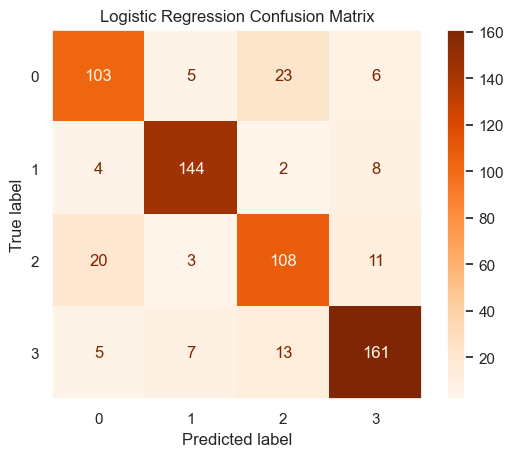

('              precision    recall  f1-score   support\n\n     Atheism       0.78      0.75      0.77       137\n    Buddhism       0.91      0.91      0.91       158\nChristianity       0.74      0.76      0.75       142\n       Islam       0.87      0.87      0.87       186\n\n    accuracy                           0.83       623\n   macro avg       0.82      0.82      0.82       623\nweighted avg       0.83      0.83      0.83       623\n',
 array([[103,   5,  23,   6],
        [  4, 144,   2,   8],
        [ 20,   3, 108,  11],
        [  5,   7,  13, 161]]))

In [155]:
train_and_display_confusion_matrix(logreg_model, X_train_tfidf,X_test_tfidf, y_train, y_test, 'Logistic Regression')

In [167]:
get_feature_names(nb_model,tfidf_vectorizer,10)

,Atheism,Buddhism,Christianity,Islam
0,god (0.0104),buddhism (0.0141),god (0.0150),allah (0.0130)
1,people (0.0088),buddha (0.0103),jesus (0.0081),islam (0.0091)
2,religion (0.0086),buddhist (0.0085),like (0.0070),muslim (0.0073)
3,atheist (0.0076),life (0.0065),just (0.0069),quran (0.0067)
4,religious (0.0075),like (0.0061),christian (0.0068),know (0.0065)
5,just (0.0074),practice (0.0058),bible (0.0066),just (0.0058)
6,like (0.0066),just (0.0053),don (0.0063),pray (0.0058)
7,believe (0.0061),know (0.0052),know (0.0058),like (0.0056)
8,don (0.0058),ve (0.0049),feel (0.0057),haram (0.0055)
9,church (0.0055),meditation (0.0048),people (0.0055),don (0.0052)
